In [2]:
import torch
import numpy as np
import datasets
from typing import List
import transformers
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
class NQDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 data: datasets.Dataset, 
                 random_seed: int, 
                 total_num: int, 
        ):
        self.data = data
        self.ids = list(range(len(data['validation'])))
        if random_seed >= 0:
            # shuffle the ids
            rng = np.random.default_rng(random_seed)
            rng.shuffle(self.ids)
            print(f"Shuffled IDs with seed {random_seed}")
        else:
            print("Not shuffling IDs")
        # select the first total_num ids
        if total_num:
            self.ids = self.ids[:total_num]

        self.few_shot_prompt = f"The following are questions (with answers).\n\n" + \
                        '\n\n'.join([self.transform_to_prompt(data['train'][i])[0] for i in range(3)]) + "\n\n"

    def transform_to_prompt(self, item):
        question_and_background = f"Question:\n{item['question'].strip()}" + f"\nAnswer:\n"
        answer = item['answer'][0].strip()
        return question_and_background + answer, question_and_background, answer

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        _id = self.ids[idx]
        item = self.data['validation'][_id]
        cur_text, cur_prefix, cur_ans = self.transform_to_prompt(item)
        entire_prompt, entire_prefix = self.few_shot_prompt + cur_text, self.few_shot_prompt + cur_prefix
        return _id, entire_prompt, cur_ans
    

def tokenize_and_align(
        tokenizer: transformers.PreTrainedTokenizer, 
        batch_prompts: List[str], 
        batch_anss: List[str], 
        max_length: int, 
        check_align: bool = True,
    ):
    tokenizer.truncation_side = "left" # ensure the answer is not truncated
    inputs = tokenizer(batch_prompts, return_tensors="pt", truncation=True, max_length=max_length, padding=True, padding_side="left")
    answer_mask = torch.zeros_like(inputs.input_ids, dtype=torch.bool)
    special_ids = torch.tensor(tokenizer.all_special_ids)
    ans_valid_positions = []

    for i, (input_ids, ans) in enumerate(zip(inputs['input_ids'], batch_anss)):
        ans_token_ids = tokenizer(ans, return_tensors="pt", truncation=True, max_length=max_length, padding=False, add_special_tokens=False).input_ids.squeeze(0)
        ans_length = ans_token_ids.size(0)
        assert not check_align or input_ids[-ans_length:].equal(ans_token_ids), \
            f"Answer not aligned: {input_ids[-ans_length:]} vs {ans_token_ids}"
        # incase the answer has unk tokne, we need to mask it
        valid_anser_mask = ~torch.isin(ans_token_ids, special_ids)
        answer_mask[i, -ans_length:] = valid_anser_mask
        ans_valid_positions.append(valid_anser_mask.nonzero(as_tuple=True)[0])
    ans_valid_positions = torch.cat(ans_valid_positions) # Shape: (num_valid,)
    return inputs, answer_mask, ans_valid_positions


In [4]:
def observe(
        model: transformers.PreTrainedModel, 
        tokenizer: transformers.PreTrainedTokenizer, 
        dataloader: torch.utils.data.DataLoader, 
        max_length: int, 
    ):
    failure_cnts = []

    lm_head = model.lm_head
    underlying_model = model.model
    chunk_size = 10 # map the hiddenstates to logits in chunks

    # Disable gradient computation for inference
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            data_ids, data_texts, data_anss= batch
            inputs, answer_mask, ans_valid_positions = tokenize_and_align(tokenizer, data_texts, data_anss, max_length)
            inputs = {k: v.to(next(iter(model.parameters())).device.type) for k, v in inputs.items()}
            answer_mask = answer_mask.to(inputs['input_ids'].device)

            # Forward pass
            hidden_states: torch.Tensor = underlying_model(**inputs).last_hidden_state
            input_ids = inputs['input_ids'].to(hidden_states.device)

            # Vectorized Processing Starts Here
            # Shift input_ids to get next_token_ids
            next_token_ids = input_ids[:, 1:].contiguous()  # Shape: (batch_size, seq_length -1)
                        
            # Get indices of valid tokens
            shifted_valid_positions = answer_mask.nonzero(as_tuple=False).to(hidden_states.device)  # Shape: (num_valid, 2)
            
            if shifted_valid_positions.numel() > 0:
                # Extract batch indices and sequence indices
                batch_indices = shifted_valid_positions[:,0]
                seq_indices = shifted_valid_positions[:,1] - 1  # Shifted by 1 to get the previous token
                # Extract the true next token IDs
                true_token_ids = next_token_ids[batch_indices, seq_indices]  # Shape: (num_valid,)

                for i in range(0, seq_indices.size(0), chunk_size):
                    chunk_batch_indices = batch_indices[i:i+chunk_size]
                    chunk_seq_indices = seq_indices[i:i+chunk_size]
                    # hidden_states: B, L, D
                    chunk_hidden_states = hidden_states[chunk_batch_indices, chunk_seq_indices, :]  # Shape: (num_valid, hidden_size)
                    chunk_logits = lm_head(chunk_hidden_states)  # Shape: (num_valid, vocab_size)
                    chunk_true_token_logits = chunk_logits[torch.arange(chunk_logits.size(0), device=chunk_logits.device), true_token_ids[i:i+chunk_size].to(chunk_logits.device)]  # Shape: (num_valid,)
                    # Count how many logits are greater than the true token's logit
                    chunk_failure_cnt = (chunk_logits > chunk_true_token_logits.unsqueeze(1)).sum(dim=1)  # Shape: (num_valid,)
                    failure_cnts.extend(chunk_failure_cnt.cpu().numpy().tolist())
               
    return failure_cnts

In [8]:
device = torch.device('cuda:0')
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B", torch_dtype="auto").to(device)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")

In [9]:
dataset = NQDataset(
    data=load_dataset("google-research-datasets/nq_open"), 
    random_seed=-1, 
    total_num=None, 
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

Using the latest cached version of the dataset since google-research-datasets/nq_open couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'nq_open' at /home/zjt/.cache/huggingface/datasets/google-research-datasets___nq_open/nq_open/0.0.0/5dd9790a83002ad084ddeb7c420dc716852c6f28 (last modified on Sun Feb  9 12:12:20 2025).


Not shuffling IDs


In [10]:
failure_cnts = observe(
    model = model,
    tokenizer = tokenizer,
    dataloader = dataloader,
    max_length = 10000,
)

  0%|          | 0/3610 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 3610/3610 [02:07<00:00, 28.39it/s]


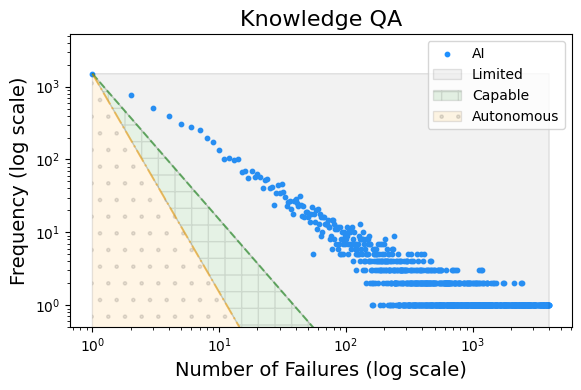

In [11]:
import matplotlib.pyplot as plt
import numpy as np

frequency = np.zeros(max(failure_cnts) + 1)
for cnt in failure_cnts:
    if cnt > 0 and cnt < len(frequency):
        frequency[cnt] += 1

plt.figure(figsize=(6, 4))

x = np.array(range(1, 4000))
# Plot histogram
plt.scatter(x, frequency[x], color="dodgerblue", s=10, label="AI")

y1 = (x.astype(np.float32))**-2 * frequency[1]
y2 = (x.astype(np.float32))**-3 * frequency[1]

# 绘制两条分界线, # label=r'$y \propto x^{-2}$',# label=r'$y \propto x^{-3}$',
plt.plot(x, y1,  color='green', linestyle='--', alpha=0.5) 
plt.plot(x, y2,  color='orange', linestyle='-.', alpha=0.5) 

# 填充不同区域
plt.fill_between(x, frequency[1], y1, color='gray', alpha=0.1, label="Limited", edgecolor="black")
plt.fill_between(x, y1, y2, color='green', alpha=0.1, hatch='+', label="Capable", edgecolor="black")
plt.fill_between(x, y2,0, color='orange', alpha=0.1, hatch='.', label="Autonomous", edgecolor="black")

# Set x-axis to log scale
plt.xscale('log')
# Set y-axis to log scale
plt.yscale('log')

# Set labels and title
plt.xlabel('Number of Failures (log scale)', fontsize=14)
plt.ylabel('Frequency (log scale)', fontsize=14)
plt.title(f'Knowledge QA', fontsize=16)

plt.tight_layout()

plt.legend(loc='upper right')

# set ylim lower bound to min(frequency)
plt.ylim(bottom=min(frequency[frequency > 0] / 2))

plt.show()
